In [2]:
# automatically reloads imported files on edits
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np

import mplhep as hep
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import hist

hep.style.use(["CMS", "firamath"])

formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
plt.rcParams.update({"font.size": 12})
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["grid.color"] = "#CCCCCC"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["figure.edgecolor"] = "none"



In [4]:
import  onnxruntime 
MAIN_DIR = "../../../"
sess_options = onnxruntime.SessionOptions()
sess_options.intra_op_num_threads = 23
sess_options.execution_mode = onnxruntime.ExecutionMode.ORT_PARALLEL
session = onnxruntime.InferenceSession(f"{MAIN_DIR}/../data/spanet-inference/spanet_pnet_all_vars_v0.onnx",sess_options)


In [5]:
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

In [6]:
events = pd.read_parquet("../../../../data/matching/23Nov18_WSel_v9_private/2018/GluGlutoHHto4B_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8/parquet")
list(events.columns)

[('ht', 0),
 ('nCentralJets', 0),
 ('nOutsideJets', 0),
 ('nFatJets', 0),
 ('vbf_selection', 0),
 ('GenHiggsEta', 0),
 ('GenHiggsEta', 1),
 ('GenHiggsPhi', 0),
 ('GenHiggsPhi', 1),
 ('GenHiggsMass', 0),
 ('GenHiggsMass', 1),
 ('GenHiggsPt', 0),
 ('GenHiggsPt', 1),
 ('GenbEta', 0),
 ('GenbEta', 1),
 ('GenbEta', 2),
 ('GenbEta', 3),
 ('GenbPhi', 0),
 ('GenbPhi', 1),
 ('GenbPhi', 2),
 ('GenbPhi', 3),
 ('GenbMass', 0),
 ('GenbMass', 1),
 ('GenbMass', 2),
 ('GenbMass', 3),
 ('GenbPt', 0),
 ('GenbPt', 1),
 ('GenbPt', 2),
 ('GenbPt', 3),
 ('ak4JetHiggsMatch', 0),
 ('ak4JetHiggsMatch', 1),
 ('ak4JetHiggsMatch', 2),
 ('ak4JetHiggsMatch', 3),
 ('ak4JetHiggsMatch', 4),
 ('ak4JetHiggsMatch', 5),
 ('ak4JetHiggsMatchIndex', 0),
 ('ak4JetHiggsMatchIndex', 1),
 ('ak4JetHiggsMatchIndex', 2),
 ('ak4JetHiggsMatchIndex', 3),
 ('ak4JetHiggsMatchIndex', 4),
 ('ak4JetHiggsMatchIndex', 5),
 ('ak4JethadronFlavour', 0),
 ('ak4JethadronFlavour', 1),
 ('ak4JethadronFlavour', 2),
 ('ak4JethadronFlavour', 3),
 ('ak

In [7]:
nevents = len(events.ak4JetPt[0])
nevents

25781

In [8]:
import vector
def make_vector(events: pd.DataFrame, obj: str):
    """Create a ``vector`` object from the columns of the dataframe"""
    mstring = "PNetMass" if obj == "ak8FatJet" else "Mass"

    return vector.array(
        {
            "pt": events[f"{obj}Pt"],
            "phi": events[f"{obj}Phi"],
            "eta": events[f"{obj}Eta"],
            "M": events[f"{obj}{mstring}"],
        }
    )

jets = make_vector(events, "ak4Jet")

In [9]:
njets = 10
jet_vars = ["PtCorr", "Eta", "SinPhi", "CosPhi", "PNetB", "Mass"]
arrays = []
for i in range(njets):
    df = pd.DataFrame(0, index=np.arange(nevents), columns=jet_vars)
    df["PtCorr"] = events.ak4JetPt[i]
    df["Eta"] = events.ak4JetEta[i]
    df["SinPhi"] = np.sin(events.ak4JetPhi[i])
    df["CosPhi"] = np.cos(events.ak4JetPhi[i])
    df["Mass"] = events.ak4JetMass[i]
    num = (events.ak4JetbtagPNetProbb[i] + events.ak4JetbtagPNetProbbb[i])
    den = (events.ak4JetbtagPNetProbb[i] + events.ak4JetbtagPNetProbbb[i] + events.ak4JetbtagPNetProbc[i] + events.ak4JetbtagPNetProbcc[i] + events.ak4JetbtagPNetProbg[i] + events.ak4JetbtagPNetProbuds[i])
    df["PNetB"] = np.where(den>0, num/den, -1)
    np_arr = df.values.T.astype(np.float32)
    arrays.append(np_arr)

Jets_data = np.transpose(np.transpose(arrays,(1,0,2)))
Jets_Pt = Jets_data[:,:,0]
MIN_PT = 20
Jets_mask = Jets_Pt > MIN_PT

In [10]:
boosted_arrays = []
fatjet_vars = ['Pt', 'Eta','SinPhi','CosPhi','PNetXbb','PNetXjj','PNetQCD','Mass']
nfatjets = 3
for i in range(nfatjets):
    df = pd.DataFrame(0, index=np.arange(nevents), columns=fatjet_vars)
    df["Pt"] = events.ak8FatJetPt[i]
    df["Eta"] = events.ak8FatJetEta[i]
    df["SinPhi"] = np.sin(events.ak8FatJetPhi[i])
    df["CosPhi"] = np.cos(events.ak8FatJetPhi[i])
    df["PNetXbb"] = events.ak8FatJetPNetXbb[i]
    df["PNetXjj"] = events.ak8FatJetPNetXjj[i]
    df["PNetQCD"] = events.ak8FatJetPNetQCD[i]
    df["Mass"] = events.ak8FatJetPNetMass[i]

    np_arr = df.values.T.astype(np.float32)
    boosted_arrays.append(np_arr)

BoostedJets_data = np.transpose(np.transpose(boosted_arrays, (1,0,2)))
MIN_FJPT = 200
BoostedJets_Pt = BoostedJets_data[:,:,0]
BoostedJets_mask = BoostedJets_Pt > MIN_FJPT

In [11]:
lep_arrays = []
lep_vars = ['Pt', 'Eta','SinPhi','CosPhi']
nleptons = 2
for i in range(nleptons):
    df = pd.DataFrame(0, index=np.arange(nevents), columns=lep_vars)
    df["Pt"] = events.LeptonPt[i]
    df["Eta"] = events.LeptonEta[i]
    df["SinPhi"] = np.sin(events.LeptonPhi[i])
    df["CosPhi"] = np.cos(events.LeptonPhi[i])

    np_arr = df.values.T.astype(np.float32)
    lep_arrays.append(np_arr)
    
Leptons_data = np.transpose(np.transpose(lep_arrays, (1,0,2)))
Leptons_Pt = Leptons_data[:,:,0]
Leptons_mask = Leptons_Pt > 20

In [13]:
tau_arrays = []
tau_vars = ['Pt', 'Eta','SinPhi','CosPhi']
ntaus = 2
for i in range(ntaus):
    df = pd.DataFrame(0, index=np.arange(nevents), columns=tau_vars)
    df["Pt"] = events.tauPt[i]
    df["Eta"] = events.tauEta[i]
    df["SinPhi"] = np.sin(events.tauPhi[i])
    df["CosPhi"] = np.cos(events.tauPhi[i])

    np_arr = df.values.T.astype(np.float32)
    tau_arrays.append(np_arr)

Taus_data = np.transpose(np.transpose(tau_arrays, (1,0,2)))
Taus_Pt = Taus_data[:,:,0]
Taus_mask = Taus_Pt > 20

In [14]:
met_arrays = [np.array([events.MET_pt.values.squeeze()])]
MET_data = np.transpose(met_arrays)
MET_mask =  MET_data[:,:,0] > 0

In [15]:
ht_arrays = [np.array([events.ht.values.squeeze()])]
HT_data = np.transpose(ht_arrays)
HT_mask = HT_data[:,:,0] > 0

In [16]:
Jets_arrays = {}
Higgs_vars = ['mass', 'pt','eta','sinphi','cosphi','dr']
for i in range(njets):
    name = 'Jet%s'%i
    Higgs_list = []
    for j in range(1, njets):
        if i == j: continue
        if int(j) < int(i): continue
        j_i = jets[:,i]
        j_j = jets[:,j]
        jj = j_i + j_j
        df = pd.DataFrame(0, index=np.arange(nevents), columns=Higgs_vars)
        df["mass"] = jj.mass
        df["pt"] = jj.pt
        df["eta"] = jj.eta
        df["sinphi"] = np.sin(jj.phi)
        df["cosphi"] = np.cos(jj.phi)
        df["dr"] = j_i.deltaR(j_j)
        df = df.fillna(0)
        np_arr = df.values.T.astype(np.float32)
        Higgs_list.append(np_arr)
    Jets_arrays[name] = Higgs_list

Jet_data = {}
Jet_mask = {}
for i in range(njets-1):
    Jet_data[i] = np.transpose(np.transpose(Jets_arrays[f'Jet{i}'],(1,0,2)))
    pt = Jet_data[i][:,:,0]
    Jet_mask[i] = pt > 20

In [17]:
input_dict = {
    "Jets_data": Jets_data, 
    "Jets_mask": Jets_mask, 
    "BoostedJets_data":BoostedJets_data, 
    "BoostedJets_mask": BoostedJets_mask, 
    "Leptons_data" : Leptons_data, 
    "Leptons_mask" : Leptons_mask, 
    'Taus_data' : Taus_data, 
    'Taus_mask': Taus_mask, 
    "MET_data" : MET_data, 
    "MET_mask": MET_mask, 
    'HT_data': HT_data, 
    "HT_mask" : HT_mask, 
    'Jet1_data' : Jet_data[0], 
    'Jet1_mask': Jet_mask[0], 
    'Jet2_data' : Jet_data[1], 
    'Jet2_mask': Jet_mask[1], 
    'Jet3_data' : Jet_data[2], 
    'Jet3_mask': Jet_mask[2], 
    'Jet4_data' : Jet_data[3], 
    'Jet4_mask': Jet_mask[3], 
    'Jet5_data' : Jet_data[4], 
    'Jet5_mask': Jet_mask[4], 
    'Jet6_data' : Jet_data[5], 
    'Jet6_mask': Jet_mask[5], 
    'Jet7_data' : Jet_data[6], 
    'Jet7_mask': Jet_mask[6], 
    'Jet8_data' : Jet_data[7], 
    'Jet8_mask': Jet_mask[7],
    'Jet9_data' : Jet_data[8], 
    'Jet9_mask': Jet_mask[8],
}


In [18]:
output_nodes = session.get_outputs()
output_names = [node.name for node in output_nodes]
output_values = session.run(output_names, input_dict)

In [20]:
output_names

['h1_assignment_probability',
 'h2_assignment_probability',
 'h3_assignment_probability',
 'bh1_assignment_probability',
 'bh2_assignment_probability',
 'bh3_assignment_probability',
 'h1_detection_probability',
 'h2_detection_probability',
 'h3_detection_probability',
 'bh1_detection_probability',
 'bh2_detection_probability',
 'bh3_detection_probability',
 'EVENT/signal']

In [17]:
# 0-8: SPANET matching
# assignment probabilities
#  max_h1, index_h1: 0 
#  max_h2, index_h2: 1
#  max_h3, index_h3: 2
# detection probabilities
#  h1Det: 6
#  h2Det: 7
#  h3Det: 8
# boosted assignment probabilities
#  bh1: 3
#  bh2: 4
#  bh3: 5
# boosted detection probabilities
#  9-11 
# 12 
#  0 ?
#  prob_hhh: 1
#  prob_qcd: 2
#  prob_tt: 3
#  prob_vjets: 4
#  prob_vv: 5
#  prob_hhh4b2tau: 6
#  prob_hh4b: 7
#  prob_hh2b2tau: 8
classification = output_values[12]

In [18]:
prob_hhh = output_values[12][:, 1]
prob_qcd = output_values[12][:, 2]
prob_tt = output_values[12][:, 3]
prob_vjets = output_values[12][:, 4]
prob_vv = output_values[12][:, 5]
prob_hhh4b2tau = output_values[12][:, 6]
prob_hh4b = output_values[12][:, 7]
prob_hh2b2tau = output_values[12][:, 8]


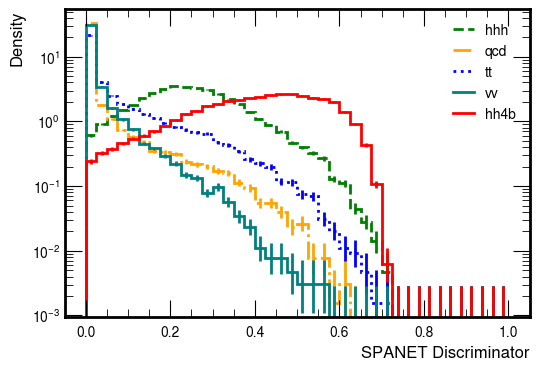

In [32]:
spanet_discr_axis = hist.axis.Regular(40, 0, 1, name="discr", label="SPANET Discriminator")
class_axis = hist.axis.StrCategory([], name="class", growth=True)
h = hist.Hist(spanet_discr_axis, class_axis)
h.fill(prob_hhh, "hhh")
h.fill(prob_qcd, "qcd")
h.fill(prob_tt, "tt")
h.fill(prob_vjets, "vjets")
h.fill(prob_vv, "vv")
h.fill(prob_hhh4b2tau, "hhh4b2tau")
h.fill(prob_hh4b, "hh4b")
h.fill(prob_hh2b2tau, "hh2b2tau")

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
legend_elements = []
linestyles = {
    "hh4b": "solid",
    "hhh": "dashed",
    "qcd": "dashdot",
    "tt": "dotted",
    "vv": "solid",
    "vjets": "dashed",
}
color_by_prob = {
    "hh4b": "red",
    "hhh": "green",
    "qcd": "orange",
    "tt": "blue",
    "vv": "teal",
    "vjets": "violet",
}
for key in ["hhh","qcd","tt","vv","hh4b"]:
    hep.histplot(
        h[{"class":key}],
        density=True,
        lw=2,
        ls=linestyles[key],
        color=color_by_prob[key],
    )
    legend_elements.append(
        Line2D([0], [0], color=color_by_prob[key], lw=2, label=key, ls=linestyles[key])
    )
ax.legend(handles=legend_elements)
ax.set_ylabel("Density")
ax.set_yscale('log')

In [22]:
session_assignment = onnxruntime.InferenceSession(f"{MAIN_DIR}/../data/spanet-inference/spanet_categorisation_v6.onnx",sess_options)


In [26]:
output_nodes_assignment = session_assignment.get_outputs()
output_names_assignment = [node.name for node in output_nodes_assignment]
output_values_assignment = session_assignment.run(output_names_assignment, input_dict)

In [25]:
output_names_assignment

['h1_assignment_probability',
 'h2_assignment_probability',
 'h3_assignment_probability',
 'bh1_assignment_probability',
 'bh2_assignment_probability',
 'bh3_assignment_probability',
 'h1_detection_probability',
 'h2_detection_probability',
 'h3_detection_probability',
 'bh1_detection_probability',
 'bh2_detection_probability',
 'bh3_detection_probability',
 'EVENT/categorisation']

In [28]:
prob_3bh0h = output_values_assignment[12][:, 1]
prob_2bh1h = output_values_assignment[12][:, 2]
prob_1bh2h = output_values_assignment[12][:, 3]
prob_0bh3h = output_values_assignment[12][:, 4]
prob_2bh0h = output_values_assignment[12][:, 5]
prob_1bh1h = output_values_assignment[12][:, 6]
prob_0bh2h = output_values_assignment[12][:, 7]
prob_1bh0h = output_values_assignment[12][:, 8]
prob_0bh1h = output_values_assignment[12][:, 9]
prob_0bh0h = output_values_assignment[12][:, 0]

In [23]:
import awkward as ak

In [90]:
def get_maximas(assignment_prob):
    assignment_prob_ak = ak.from_numpy(np.triu(assignment_prob[:][:,0:njets,0:njets]))
    arr_flat = ak.flatten(assignment_prob_ak, axis=2)
    max_indices = ak.argsort(arr_flat,ascending=False,axis=1).to_numpy()[:,:45]
    max_values = arr_flat[max_indices]
    return max_indices, max_values

# h1 - h3 assignment probability
index_h1, prob_h1 = get_maximas(output_values[0][:])
index_h2, prob_h2 = get_maximas(output_values[1][:])
index_h3, prob_h3 = get_maximas(output_values[2][:])

# boosted h1 - h3 assignment probability
h1Det = output_values[6][:]
h2Det = output_values[7][:]
h3Det = output_values[8][:]


In [91]:
bh1 = output_values[3][:]
bh2 = output_values[4][:]
bh3 = output_values[5][:]

#boosted_higgs = find_boosted_higgs(bh1,bh2,bh3)
bh1[0]

array([1.1151166e-23, 3.4477821e-24, 1.2822819e-24, 2.2233398e-24,
       1.6066983e-24, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 4.7727684e-09, 1.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 1.6836128e-24, 1.5062475e-24, 2.9165332e-24,
       1.9595323e-24, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 6.1614072e-24, 1.5687968e-24,
       4.5108782e-24, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 1.4782639e-24, 3.1196157e-24,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 2.3670217e-24, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e

In [92]:
bh1[0][10]

4.7727684e-09

In [93]:
bh1[0][11]

1.0

In [94]:
bh1[0][12]

0.0